In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

## I. Data cleaning and EDA

### import dataset from csv file

In [2]:
# import dataset from csv
df = pd.read_csv("accepted_2007_to_2018Q4.csv", low_memory=False)

In [3]:
# number of col and shape of dataset
df.shape

(2260701, 151)

### Cleaning target variable

In [4]:
# target variable
df.loan_status.value_counts()
# need to select default and not default

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

What Is a Default?
Default is the failure to repay a debt, including interest or principal, on a loan or security. A default can occur when a borrower is unable to make timely payments, misses payments, or avoids or stops making payments. Individuals, businesses, and even countries can default if they cannot keep up their debt obligations. Default risks are often calculated well in advance by creditors.

In [5]:
# Choose "Full paid" and "Current" as "Normal" loan and the rest are Default
# except'Does not meet the credit policy. Status:Fully Paid' and 'Does not meet the credit policy. Status:Charged Off'
df_clean = df[~df["loan_status"].isin(['Does not meet the credit policy. Status:Fully Paid',
                                    'Does not meet the credit policy. Status:Charged Off'])]                                                               

In [6]:
df_clean.loc[:, "loan_status"] = df_clean["loan_status"].apply(lambda x: "Normal" if x in ["Fully Paid", "Current"] else "Default" )


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Drop high missing value columns

In [7]:
# have a look on missing value for each column
df.isnull().sum().sort_values(ascending=False)

member_id                                     2260701
orig_projected_additional_accrued_interest    2252050
hardship_loan_status                          2249784
hardship_dpd                                  2249784
hardship_reason                               2249784
                                               ...   
initial_list_status                                33
revol_bal                                          33
hardship_flag                                      33
fico_range_high                                    33
id                                                  0
Length: 151, dtype: int64

In [8]:
# mean null value for all col
mean_null_val = df.isnull().sum().mean()

In [9]:
# drop column which have missing value greater that 20%
a = df_clean.isnull().sum().sort_values(ascending=False)
drop_list = a[a>mean_null_val].index
print(drop_list)
df_clean = df_clean.drop(columns=drop_list)

Index(['member_id', 'orig_projected_additional_accrued_interest',
       'hardship_loan_status', 'hardship_dpd', 'hardship_reason',
       'hardship_status', 'deferral_term', 'hardship_amount',
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_length', 'hardship_type', 'hardship_payoff_balance_amount',
       'hardship_last_payment_amount', 'settlement_percentage',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_term',
       'sec_app_mths_since_last_major_derog', 'sec_app_revol_util',
       'revol_bal_joint', 'sec_app_chargeoff_within_12_mths',
       'sec_app_num_rev_accts', 'sec_app_open_act_il', 'sec_app_open_acc',
       'sec_app_mort_acc', 'sec_app_inq_last_6mths',
       'sec_app_earliest_cr_line', 'sec_app_fico_range_high',
       'sec_app_fico_range_low', 'sec_app_collections_12_mths_ex_med',
       'verification_status_joint', 'dti_joint', 'annual_inc_joint', 'des

### Drop columns which have only one unique value

In [10]:
# drop col that have only one values
drop_list = []
for i in df_clean.columns:
    unique_val = df[i].drop_duplicates().count()
    if unique_val <= 1:
        drop_list.append(i)
print(drop_list)
df_clean = df_clean.drop(columns=drop_list)

['policy_code']


## II. Feature Engineer

### Drop highly correlated feature

In [11]:
# Check only column which are float
list_col = []
obj_col = df_clean.dtypes[df_clean.dtypes != "object"].index
for i in df_clean[obj_col].columns:
    if df_clean.loc[:,i].drop_duplicates().count() > 10:
        list_col.append(i)
df_corr = df_clean[list_col]

In [12]:
# unstacking correlation to check highest correlation pairs
c = df_corr.corr().abs()
unstack_corr = c.unstack()
pairs = unstack_corr.sort_values(ascending=False)

corr_pairs = pd.DataFrame(pairs).drop_duplicates().reset_index()
corr_pairs.columns = ['feature1', 'feature2', 'corr']

# check feature pairs above 0.9 in correlation

cond1 = (corr_pairs.feature1 != corr_pairs.feature2)
cond2 = (corr_pairs['corr']>0.9)

corr_pairs[cond1 & cond2]

,feature1,feature2,corr
1,fico_range_high,fico_range_low,1.000000
2,out_prncp_inv,out_prncp,0.999999
3,loan_amnt,funded_amnt,0.999764
4,total_pymnt_inv,total_pymnt,0.999539
5,funded_amnt_inv,funded_amnt,0.999513
6,loan_amnt,funded_amnt_inv,0.999228
7,num_sats,open_acc,0.998966
8,num_rev_tl_bal_gt_0,num_actv_rev_tl,0.983638
9,tot_hi_cred_lim,tot_cur_bal,0.975582
10,collection_recovery_fee,recoveries,0.971189


In [13]:
# define func for plot correlated column
def scatter_plot(df):
    _, ncol = df.shape
    if ncol > 2:
        fig, axs = plt.subplots(1, ncol-1, figsize=(5*(ncol-1),5), sharey=True)
        for i in range(ncol-1):
            axs[i].set_ylabel(df.columns[0])
            axs[i].set_xlabel(df.columns[i+1])
            axs[i].set_title(f"{df.columns[0]} vs {df.columns[i+1]}")
            axs[i].scatter(df.iloc[:, i+1], df.iloc[:,0])
    elif ncol == 2:
        fig, ax = plt.subplots(figsize=(5,5))
        ax.scatter(df.iloc[:, 1], df.iloc[:,0])
        ax.set_ylabel(df.columns[0])
        ax.set_xlabel(df.columns[1])
        ax.set_title(f"{df.columns[1]} vs {df.columns[0]}")
    plt.show()

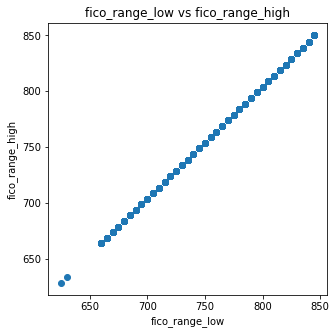

In [14]:
# check fico_range_high and fico_range_low correlation
scatter_plot(df_corr[["fico_range_high", "fico_range_low"]])

In [15]:
# drop one of them in this case drop fico_range_low
df_clean = df_clean.drop(columns="fico_range_low")

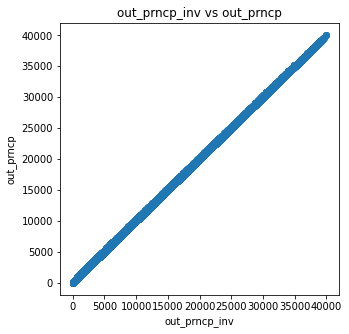

In [16]:
# check "out_prncp", "out_prncp_inv" correlation
scatter_plot(df_corr[["out_prncp", "out_prncp_inv"]])

In [17]:
# drop one of them in this case drop out_prncp_inv
df_clean = df_clean.drop(columns="out_prncp_inv")

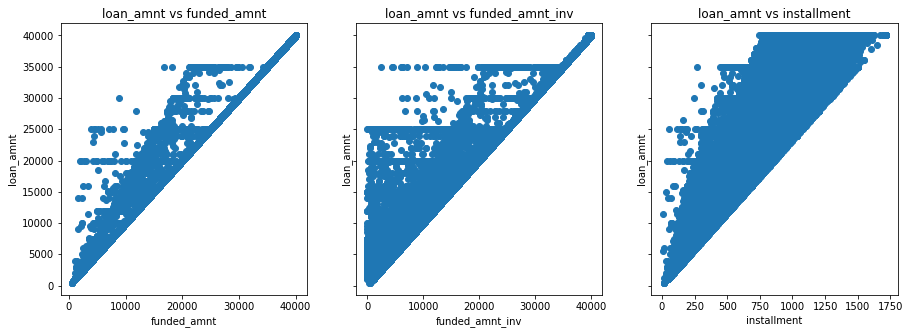

In [18]:
# check "funded_amnt", "loan_amnt", "funded_amnt_inv", "installment" correlation
scatter_plot(df_corr[["loan_amnt", "funded_amnt", "funded_amnt_inv", "installment"]])

In [19]:
# keep only loan_amnt
df_clean = df_clean.drop(columns=["funded_amnt", "funded_amnt_inv", "installment"])

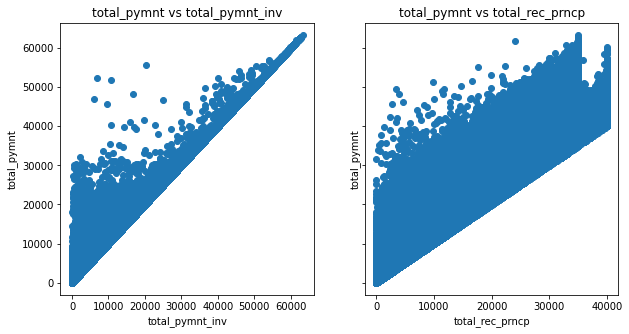

In [20]:
# check "total_pymnt_inv", "total_pymnt", "total_rec_prncp" correlation
scatter_plot(df_corr[["total_pymnt", "total_pymnt_inv", "total_rec_prncp"]])

In [21]:
# keep only total_pymnt
df_clean = df_clean.drop(columns=["total_pymnt_inv", "total_rec_prncp"])

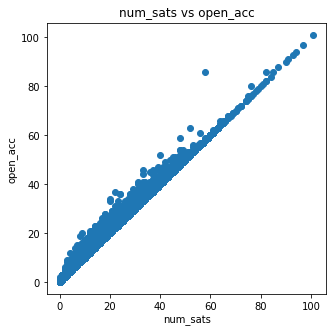

In [22]:
# check "num_sats", "open_acc" correlation
scatter_plot(df_corr[["open_acc", "num_sats"]])

In [23]:
# drop num_sats
df_clean = df_clean.drop(columns=["num_sats"])

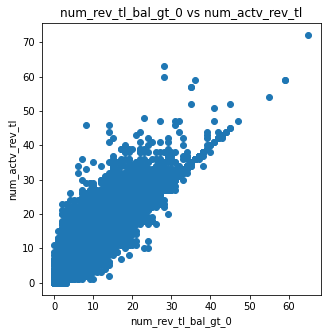

In [24]:
# check "num_actv_rev_tl", "num_rev_tl_bal_gt_0" correlation
scatter_plot(df_corr[["num_actv_rev_tl", "num_rev_tl_bal_gt_0"]])

In [25]:
# drop num_rev_tl_bal_gt_0
df_clean = df_clean.drop(columns=["num_rev_tl_bal_gt_0"])

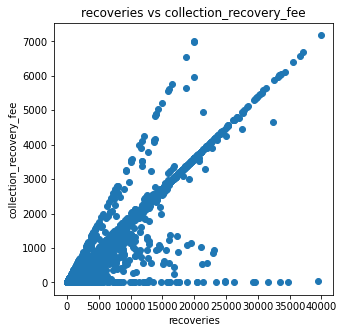

In [26]:
# check "collection_recovery_fee", "recoveries" correlation
scatter_plot(df_corr[["collection_recovery_fee", "recoveries"]])

In [27]:
# drop num_rev_tl_bal_gt_0
df_clean = df_clean.drop(columns=["collection_recovery_fee"])

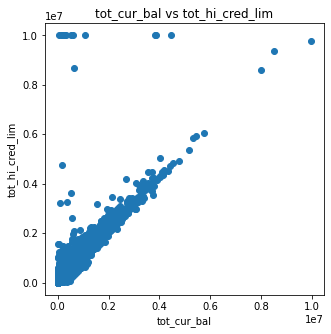

In [28]:
# check "tot_hi_cred_lim", "tot_cur_bal" correlation
scatter_plot(df_corr[["tot_hi_cred_lim", "tot_cur_bal"]])

In [29]:
# drop tot_hi_cred_lim
df_clean = df_clean.drop(columns=["tot_hi_cred_lim"])

In [30]:
# check dataset shape again
df_clean.shape

(2257952, 81)

### Drop object column which irrelavant

In [31]:
# take a look at object col
df_clean.dtypes[df_clean.dtypes == "object"].shape

(24,)

In [32]:
# take a look at col which have unique value greater that 10
list_col = []
obj_col = df_clean.dtypes[df_clean.dtypes == "object"].index
for i in df_clean[obj_col].columns:
    if df_clean.loc[:,i].drop_duplicates().count() > 10:
        list_col.append(i)
df_clean[list_col].head()

,id,sub_grade,emp_title,emp_length,issue_d,url,purpose,title,zip_code,addr_state,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,68407277,C4,leadman,10+ years,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,190xx,PA,Aug-2003,Jan-2019,Mar-2019
1,68355089,C1,Engineer,10+ years,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,small_business,Business,577xx,SD,Dec-1999,Jun-2016,Mar-2019
2,68341763,B4,truck driver,10+ years,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,home_improvement,NaN,605xx,IL,Aug-2000,Jun-2017,Mar-2019
3,66310712,C5,Information Systems Officer,10+ years,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,076xx,NJ,Sep-2008,Feb-2019,Mar-2019
4,68476807,F1,Contract Specialist,3 years,Dec-2015,https://lendingclub.com/browse/loanDetail.acti...,major_purchase,Major purchase,174xx,PA,Jun-1998,Jul-2016,Mar-2018


In [33]:
df_clean["emp_title"].value_counts()

Teacher                                 38824
Manager                                 34298
Owner                                   21977
Registered Nurse                        15867
Driver                                  14753
                                        ...  
tax Preparer                                1
Photo Editor Consultant                     1
County executive director                   1
DOJ OIA Law Clerk                           1
Director, Business and Legal Affairs        1
Name: emp_title, Length: 511193, dtype: int64

In [34]:
df_clean["title"].value_counts()

Debt consolidation                         1153280
Credit card refinancing                     469690
Home improvement                            137430
Other                                       127714
Major purchase                               44840
                                            ...   
Las Vegas                                        1
Loan Credit Card                                 1
2013 PLAN                                        1
credit card consolidation plus personal          1
Debt Consol Lending Club                         1
Name: title, Length: 61685, dtype: int64

In [35]:
# drop all except ["sub_grade", "purpose", "addr_state" ,"emp_length"]
list_col = []
obj_col = df_clean.dtypes[df_clean.dtypes == "object"].index
for i in df_clean[obj_col].columns:
    if df_clean.loc[:,i].drop_duplicates().count() > 10:
        list_col.append(i)
drop_list = [i for i in list_col if i not in ["sub_grade", 
                                              "purpose", 
                                              "emp_length",
                                              "addr_state"]]
df_clean = df_clean.drop(columns=drop_list)

In [36]:
# take a look at object col again
obj_col = df_clean.dtypes[df_clean.dtypes == "object"].index
df_clean[obj_col].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,addr_state,initial_list_status,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,C4,10+ years,MORTGAGE,Not Verified,Normal,n,debt_consolidation,PA,w,Individual,N,Cash,N
1,36 months,C,C1,10+ years,MORTGAGE,Not Verified,Normal,n,small_business,SD,w,Individual,N,Cash,N
2,60 months,B,B4,10+ years,MORTGAGE,Not Verified,Normal,n,home_improvement,IL,w,Joint App,N,Cash,N
3,60 months,C,C5,10+ years,MORTGAGE,Source Verified,Normal,n,debt_consolidation,NJ,w,Individual,N,Cash,N
4,60 months,F,F1,3 years,MORTGAGE,Source Verified,Normal,n,major_purchase,PA,w,Individual,N,Cash,N


In [37]:
# chech data shape again
df_clean.shape

(2257952, 72)

### Drop N/A rows

In [38]:
df_clean.dropna().shape

(1684854, 72)

In [39]:
df_clean = df_clean.dropna()

### Dtype conversion from object to float

In [40]:
# take alook at obj col one more time
obj_col = df_clean.dtypes[df_clean.dtypes == "object"].index
df_clean[obj_col].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,addr_state,initial_list_status,application_type,hardship_flag,disbursement_method,debt_settlement_flag
0,36 months,C,C4,10+ years,MORTGAGE,Not Verified,Normal,n,debt_consolidation,PA,w,Individual,N,Cash,N
1,36 months,C,C1,10+ years,MORTGAGE,Not Verified,Normal,n,small_business,SD,w,Individual,N,Cash,N
2,60 months,B,B4,10+ years,MORTGAGE,Not Verified,Normal,n,home_improvement,IL,w,Joint App,N,Cash,N
4,60 months,F,F1,3 years,MORTGAGE,Source Verified,Normal,n,major_purchase,PA,w,Individual,N,Cash,N
6,36 months,B,B2,10+ years,MORTGAGE,Not Verified,Normal,n,debt_consolidation,MN,f,Individual,N,Cash,N


In [41]:
# check term value count
df_clean["term"].value_counts()

 36 months    1177503
 60 months     507351
Name: term, dtype: int64

In [42]:
# convert term to float
df_clean.term = df_clean["term"].str.replace("months", "").astype(float)

In [43]:
# check emp_length value count
df_clean["emp_length"].value_counts()

10+ years    600088
2 years      162731
< 1 year     148198
3 years      144266
1 year       117368
5 years      110544
4 years      108420
6 years       81546
7 years       74162
8 years       73858
9 years       63673
Name: emp_length, dtype: int64

In [44]:
# convert emp_length to float
dic = dict(zip(df_clean["emp_length"].value_counts().sort_index().index,[1 ,10 ,2 ,3 ,4 ,5 ,6 ,7 ,8 ,9 ,0]))
df_clean.loc[:, "emp_length"] = df_clean["emp_length"].map(dic).astype(float)


### Remove outlier

In [45]:
# remove outlier
from scipy import stats
df_zscore = df_clean[df_clean.columns[(df_clean.dtypes == "float") & (df_clean.columns != "loan_status")]]
z_scores = stats.zscore(df_zscore)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)

In [46]:
df_clean[filtered_entries].shape

(1054011, 72)

In [47]:
df_clean = df_clean[filtered_entries]

### Feature encoding

In [48]:
# Check binary col
print(df_clean.initial_list_status.value_counts())
print(df_clean.application_type.value_counts())
print(df_clean.hardship_flag.value_counts())
print(df_clean.disbursement_method.value_counts())
print(df_clean.debt_settlement_flag.value_counts())
print(df_clean.pymnt_plan.value_counts())

w    729982
f    324029
Name: initial_list_status, dtype: int64
Individual    1007792
Joint App       46219
Name: application_type, dtype: int64
N    1053714
Y        297
Name: hardship_flag, dtype: int64
Cash         1015470
DirectPay      38541
Name: disbursement_method, dtype: int64
N    1043289
Y      10722
Name: debt_settlement_flag, dtype: int64
n    1053796
y        215
Name: pymnt_plan, dtype: int64


In [49]:
dic = {"n": 0, "y": 1,
       "N": 0, "Y": 1,
       "w": 1, "f": 0, 
       "Individual": 1, "Joint App": 0, 
       "Cash": 1, "DirectPay": 0}

# encode
df_clean.loc[:, "hardship_flag"] = df_clean.hardship_flag.map(dic).astype(float)
df_clean.loc[:, "debt_settlement_flag"] = df_clean.debt_settlement_flag.map(dic).astype(float)
df_clean.loc[:, "pymnt_plan"] = df_clean.pymnt_plan.map(dic).astype(float)

# encode and create new column
df_clean["initial_list_status_w"] = df_clean.initial_list_status.map(dic).astype(float)
df_clean["application_type_Individual"] = df_clean.application_type.map(dic).astype(float)
df_clean["disbursement_method_Cash"] = df_clean.disbursement_method.map(dic).astype(float)

# drop original columns
df_clean = df_clean.drop(columns=["initial_list_status", 
                                  "application_type", 
                                  "disbursement_method"])

In [50]:
# check grade value count
df_clean.shape

(1054011, 72)

In [51]:
# check home_ownership
df_clean.home_ownership.value_counts()

MORTGAGE    507260
RENT        438483
OWN         107757
ANY            462
OTHER           30
NONE            19
Name: home_ownership, dtype: int64

In [52]:
# replace NONE with ANY
df_clean.home_ownership = df_clean.home_ownership.str.replace("NONE", "ANY")

In [53]:
# check verification_status
df_clean.verification_status.value_counts()

Source Verified    443371
Not Verified       377795
Verified           232845
Name: verification_status, dtype: int64

In [54]:
# check purpose
df_clean.purpose.value_counts()


debt_consolidation    599698
credit_card           252183
home_improvement       63845
other                  62256
major_purchase         22017
medical                12266
car                    10685
small_business          9279
vacation                7613
moving                  7166
house                   5860
renewable_energy         617
wedding                  525
educational                1
Name: purpose, dtype: int64

## III. Credit default classification

In [55]:
# function for encode object columns
def fea_encode(df, target):
    obj_col = df.dtypes[(df.dtypes == "object") & (df.columns != target)].index
    for i in obj_col:
        df = pd.get_dummies(df, columns = [i], prefix='', prefix_sep='', drop_first=True)
    return df

In [56]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [57]:
# choose logistic regression as baseline model
df_default = df_clean.copy()

In [58]:
df_test = fea_encode(df_default, "loan_status")

In [59]:
# pre process
X = df_test.loc[:, df_test.columns != 'loan_status'].values
y = df_test.loan_status.values

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [61]:
# scaling 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [62]:
# scaling 
X_test_scaled = scaler.transform(X_test)
predictions = logisticRegr.predict(X_test_scaled)
# Use score method to get accuracy of model
score = round(logisticRegr.score(X_test_scaled, y_test), 4)
print(score*100)

98.75


In [63]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[ 20243   2495]
 [   146 187919]]


### Feature deduction

In [64]:
# baseline model accuracy 
base_acc = score
feature_list = df_default.columns[df_default.columns != "loan_status"]

In [65]:
print(f"baseline accuracy: {base_acc}")
print("-"*40)
count = 1
for i in feature_list:
    df_test = df_default.drop(columns=i)
    df_test = fea_encode(df_test, "loan_status")
    # pre process
    X = df_test.loc[:, df_test.columns != 'loan_status'].values
    y = df_test.loan_status.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression(max_iter=1000)
    logisticRegr.fit(X_train_scaled, y_train)
    X_test_scaled = scaler.transform(X_test)
    predictions = logisticRegr.predict(X_test_scaled)
    # Use score method to get accuracy of model
    score = round(logisticRegr.score(X_test_scaled, y_test), 4)
    print(f"{count}/{len(feature_list)}. without '{i}' : {score}")
    if score >= base_acc:
        df_default = df_default.drop(columns=i)
        base_acc = score
        print(f"drop '{i}'")
        print(f"new baseline accuracy: {base_acc}")
    print("-"*40)
    count += 1
feature_list = df_default.columns
score_default = score

baseline accuracy: 0.9875
----------------------------------------
1/71. without 'loan_amnt' : 0.972
----------------------------------------
2/71. without 'term' : 0.9875
drop 'term'
new baseline accuracy: 0.9875
----------------------------------------
3/71. without 'int_rate' : 0.9875
drop 'int_rate'
new baseline accuracy: 0.9875
----------------------------------------
4/71. without 'grade' : 0.9875
drop 'grade'
new baseline accuracy: 0.9875
----------------------------------------
5/71. without 'sub_grade' : 0.9874
----------------------------------------
6/71. without 'emp_length' : 0.9874
----------------------------------------
7/71. without 'home_ownership' : 0.9875
drop 'home_ownership'
new baseline accuracy: 0.9875
----------------------------------------
8/71. without 'annual_inc' : 0.9874
----------------------------------------
9/71. without 'verification_status' : 0.9875
drop 'verification_status'
new baseline accuracy: 0.9875
----------------------------------------
10/

drop 'application_type_Individual'
new baseline accuracy: 0.9876
----------------------------------------
71/71. without 'disbursement_method_Cash' : 0.9875
----------------------------------------


In [66]:
# shape after feature deduction from 71 to 23
df_default.shape

(1054011, 23)

In [67]:
# encoding
df_test = fea_encode(df_default, "loan_status")

In [68]:
# pre process
X = df_test.loc[:, df_test.columns != 'loan_status'].values
y = df_test.loan_status.values

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# scalling
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_scaled, y_train)

# DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree.fit(X_train_scaled, y_train)

# scalling
X_test_scaled = scaler.transform(X_test)

# accuracy score
score_default_clf = round(clf.score(X_test_scaled, y_test), 4)
score_default_decision_tree = round(decision_tree.score(X_test_scaled, y_test), 4)

In [69]:
print(f"logistic regression {score}")
print(f"Random Forest {score_default_clf}")
print(f"Decision Tree {score_default_decision_tree}")

logistic regression 0.9875
Random Forest 0.8922
Decision Tree 0.9536


### III. Credit grade classification

In [70]:
# choose logistic regression as baseline model
df_grade = df_clean.copy()
df_grade = df_grade.drop(columns=["sub_grade", "loan_status"])

In [71]:
df_test = fea_encode(df_grade, "grade")

# pre process
X = df_test.loc[:, df_test.columns != 'grade'].values
y = df_test.grade.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# scaling 
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# all parameters not specified are set to their defaults
logisticRegr = LogisticRegression(max_iter=1000)
logisticRegr.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
predictions = logisticRegr.predict(X_test_scaled)

# Use score method to get accuracy of model
score = round(logisticRegr.score(X_test_scaled, y_test), 4)
print(score*100)

88.46000000000001


In [72]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[37509  1982     0     0     0     0     0]
 [ 2799 58101  4380     0     0     0     0]
 [   34  3914 57689  1979     0     0     0]
 [   14     0  3013 24949  1625     0     0]
 [    7     0     0  2832  7339   455     4]
 [    0     0     0     0  1044   838    39]
 [    1     0     0     0    12   196    48]]


In [73]:
# baseline model accuracy 
base_acc = score
feature_list = df_grade.columns[df_grade.columns != "grade"]

### Feature deduction

In [ ]:
print(f"baseline accuracy: {base_acc}")
print("-"*40)
count = 1
for i in feature_list:
    df_test = df_grade.drop(columns=i)
    df_test = fea_encode(df_test, "grade")
    
    # pre process
    X = df_test.loc[:, df_test.columns != 'grade'].values
    y = df_test.grade.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    
    # all parameters not specified are set to their defaults
    logisticRegr = LogisticRegression(max_iter=1000)
    logisticRegr.fit(X_train_scaled, y_train)
    X_test_scaled = scaler.transform(X_test)
    predictions = logisticRegr.predict(X_test_scaled)
    
    # Use score method to get accuracy of model
    score = round(logisticRegr.score(X_test_scaled, y_test), 4)
    print(f"{count}/{len(feature_list)}. without '{i}' : {score}")
    if score >= base_acc:
        df_grade = df_grade.drop(columns=i)
        base_acc = score
        print(f"drop '{i}'")
        print(f"new baseline accuracy: {base_acc}")
    print("-"*40)
    count += 1
feature_list = df.grade.columns
score_grade = score

baseline accuracy: 0.8846
----------------------------------------
1/69. without 'loan_amnt' : 0.8846
drop 'loan_amnt'
new baseline accuracy: 0.8846
----------------------------------------
2/69. without 'term' : 0.8836
----------------------------------------
3/69. without 'int_rate' : 0.5835
----------------------------------------
4/69. without 'emp_length' : 0.8846
drop 'emp_length'
new baseline accuracy: 0.8846
----------------------------------------
5/69. without 'home_ownership' : 0.8846
drop 'home_ownership'
new baseline accuracy: 0.8846
----------------------------------------
6/69. without 'annual_inc' : 0.8844
----------------------------------------
7/69. without 'verification_status' : 0.8841
----------------------------------------
8/69. without 'pymnt_plan' : 0.8846
drop 'pymnt_plan'
new baseline accuracy: 0.8846
----------------------------------------
9/69. without 'purpose' : 0.8835
----------------------------------------
10/69. without 'addr_state' : 0.8844
-------

In [ ]:
# encoding
df_test = fea_encode(df_grade, "grade")

# pre process
X = df_test.loc[:, df_test.columns != 'grade'].values
y = df_test.grade.values

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# scalling
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_scaled, y_train)

# DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
decision_tree.fit(X_train_scaled, y_train)

# scalling
X_test_scaled = scaler.transform(X_test)

# accuracy score
score_grade_decision_tree = round(decision_tree.score(X_test_scaled, y_test), 4)
score_grade_clf = round(clf.score(X_test_scaled, y_test), 4)

In [ ]:
print(f"logistic regression {score_grade}")
print(f"Random Forest {score_grade_clf}")
print(f"Decision Tree {score_grade_decision_tree}")